In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
tstamp = time.perf_counter_ns()

In [3]:
## import human data for fitting
import pandas as pd
hdf = pd.read_csv('../human_data.csv')
humanB_acc,humanI_acc = hdf.loc[:,('blocked mean','interleaved mean')].values.T

In [4]:
## processing data
def get_sm(xth):
  """ 
  given x_t_hat from subject
  [trial,layer,node]
  get 2afc normalized softmax for layer 2/3
  return: [trial,layer2/3,node56/78]
  """
  nodes = {2:(5,6),3:(7,8)} 
  L = [] # layer 2 and 3
  for l,ns in nodes.items():
    y = xth[:,l,ns]
#     y /= y.sum(1,keepdims=True) # if nrom required
#     print(y/y.sum(1,keepdims=True))
#     y = softmax(xth[:,l,ns],-1)
    L.append(y)
  return np.array(L)

def get_acc(data):
  """ 
  returns 2afc softmax of 
  layer 2/3 transitions
  """
  ysm = get_sm(data['xth'])
  L = []
  for i in range(2):
    ysml = ysm[i]
    yt = data['exp'][:,i+3] 
    pr_yt = ysml[range(len(ysml)),yt - (5+2*i)] # 
    L.append(pr_yt)
  return np.array(L)

### RUN EXP
def run_batch_exp(ns,args,condL=['blocked','interleaved']):
  """
  """
  dataL = []
  for i in range(ns):
    task = Task()
    sem = SEM(args['sch'])
    exp,curr  = task.generate_experiment(**args['exp'])
    data = sem.run_exp(exp)
    data['exp']=exp
    dataL.append(data)
  return dataL

def run_batch_expBI(ns,args):
  """ return shape [(B/I),seed,trial]
  """
  L = []
  for curr in ['blocked','interleaved']:
    args['exp']['condition'] = curr
    dataL = run_batch_exp(ns,args,condL=['blocked','interleaved'])
    acc = np.array([get_acc(data) for data in dataL]).mean(1) # mean over layer
    L.append(acc)
  return np.array(L)

In [5]:
alfaL = [1.4,1.5,2.5]
betaL = [600,1000,5000]
betabL = [85,100,205] # bt
lmdaL = [0.005,0.01,0.08]

param_setsize = len(alfaL)*len(betaL)*len(lmdaL)*len(betabL)
print(param_setsize)
print(alfaL)
print(betaL)
print(betabL)
print(lmdaL)

expargs = {
  'condition':None,
  'n_train':160,
  'n_test':40
}
ns = 20

81
[1.4, 1.5, 2.5]
[600, 1000, 5000]
[85, 100, 205]
[0.005, 0.01, 0.08]


In [6]:
L = []
# for idx,(alfa,beta,lmda) in enumerate(product(alfaL,betaL,lmdaL)):
for idx,(alfa,beta,betab,lmda) in enumerate(product(alfaL,betaL,betabL,lmdaL)):
  params = alfa,beta,lmda
  print(idx/param_setsize,alfa,beta,lmda)
  schargs = {
    'concentration':alfa,
    'stickiness_wi':beta,
    'stickiness_bt':betab,
    'sparsity':lmda
  }
  
  argsD = {
    'sch':schargs,
    'exp':expargs
  }
  model_seed_acc = run_batch_expBI(ns,argsD) # [B/I,seeds,trials]
  model_acc = model_seed_acc.mean(1)
  model_testacc = model_acc[:,-40:].mean(1)
  
  mseB = np.mean((model_acc[0] - humanB_acc)**2)
  mseI = np.mean((model_acc[1] - humanI_acc)**2)
  
  ## record
  gsD = {**schargs,
        'mseB':mseB,
        'mseI':mseI,
        'testaccB':model_testacc[0],
        'testaccI':model_testacc[1],
        }

  L.append(gsD)
gsdf = pd.DataFrame(L)

0.0 1.4 600 0.005
0.012345679012345678 1.4 600 0.01
0.024691358024691357 1.4 600 0.08
0.037037037037037035 1.4 600 0.005
0.04938271604938271 1.4 600 0.01
0.06172839506172839 1.4 600 0.08
0.07407407407407407 1.4 600 0.005
0.08641975308641975 1.4 600 0.01
0.09876543209876543 1.4 600 0.08
0.1111111111111111 1.4 1000 0.005
0.12345679012345678 1.4 1000 0.01
0.13580246913580246 1.4 1000 0.08
0.14814814814814814 1.4 1000 0.005
0.16049382716049382 1.4 1000 0.01
0.1728395061728395 1.4 1000 0.08
0.18518518518518517 1.4 1000 0.005
0.19753086419753085 1.4 1000 0.01
0.20987654320987653 1.4 1000 0.08
0.2222222222222222 1.4 5000 0.005
0.2345679012345679 1.4 5000 0.01
0.24691358024691357 1.4 5000 0.08
0.25925925925925924 1.4 5000 0.005
0.2716049382716049 1.4 5000 0.01
0.2839506172839506 1.4 5000 0.08
0.2962962962962963 1.4 5000 0.005
0.30864197530864196 1.4 5000 0.01
0.32098765432098764 1.4 5000 0.08
0.3333333333333333 1.5 600 0.005
0.345679012345679 1.5 600 0.01
0.35802469135802467 1.5 600 0.08
0.370

In [7]:
gsdf['testacc-diff'] = gsdf['testaccB'] - gsdf['testaccI']
gsdf['mse'] = gsdf['mseB'] + gsdf['mseI']
## MSE BLOCKED ONLY
# gsdf['mse'] = gsdf['mseB'] 
# gsdf = gsdf.sort_values('testacc-diff',ascending=False)
gsdf = gsdf.sort_values('mse',ascending=True)
best_param = gsdf.iloc[0]

# best fit

In [8]:
print(best_param)
a,bw,bb,l = best_param[:4]

schargs_prime = {
  'concentration':a,
  'stickiness_wi':bw,
  'stickiness_bt':bb,
  'sparsity':l
}
expargs = {
  'condition':None,
  'n_train':160,
  'n_test':40
}
args = {
  'sch':schargs_prime,
  'exp':expargs
  }

ns = 20
accB,accI = run_batch_expBI(ns,args).mean(1) # over seeds


concentration       1.400000
stickiness_wi    5000.000000
stickiness_bt     100.000000
sparsity            0.080000
mseB                0.005517
mseI                0.019511
testaccB            0.960890
testaccI            0.502166
testacc-diff        0.458723
mse                 0.025028
Name: 23, dtype: float64


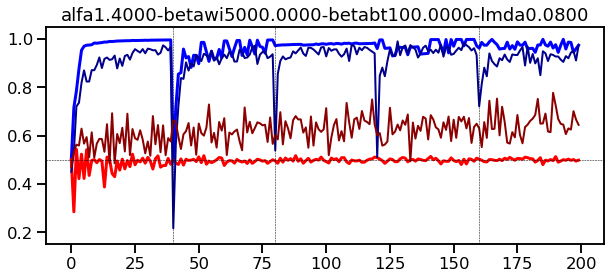

In [9]:
plt.figure(figsize=(10,4))
## plot model
plt.plot(accB,c='b',lw=3)
plt.plot(accI,c='r',lw=3)
# human
plt.plot(humanB_acc,c='darkblue',lw=2)
plt.plot(humanI_acc,c='darkred',lw=2)
# gridlines
plt.axhline(0.5,c='k',lw=0.5,ls='--')
for v in [40,80,160]:
  plt.axvline(v,c='k',lw=0.5,ls='--')
  
paramstr = "alfa%.4f-betawi%.4f-betabt%.4f-lmda%.4f"%(a,bw,bb,l)
plt.title(paramstr)
plt.ylim(0.15,1.05)
plt.savefig('figures/scratch/bestfitGS-%i'%tstamp)

# analysis

In [10]:
pL = ['concentration','stickiness_bt','stickiness_wi','sparsity']

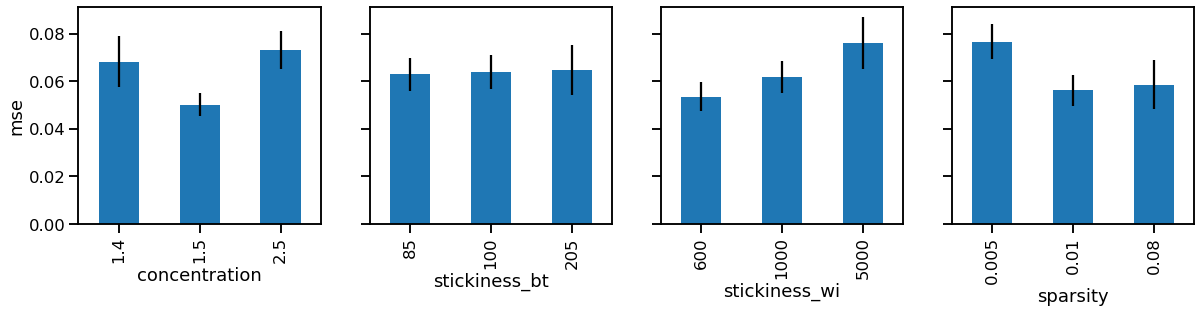

In [11]:
f,axa = plt.subplots(1,4,figsize=(20,4),sharey=True)
for i in range(4):
  ax = axa[i]
  msegroup = gsdf.groupby(pL[i]).mse
  M = msegroup.mean()
  S = msegroup.std()/np.sqrt(msegroup.count())
#   ax.bar(M)
  M.plot.bar(ax=ax,yerr=S)
#   ax.bar(M,yerr=S)
#   ax.fill_between(M.index,M+S,M-S,alpha=0.5)
  ax.set_xlabel(pL[i])
  ax.set_ylabel('mse')

plt.savefig('figures/scratch/mse-by-param-%i'%tstamp)

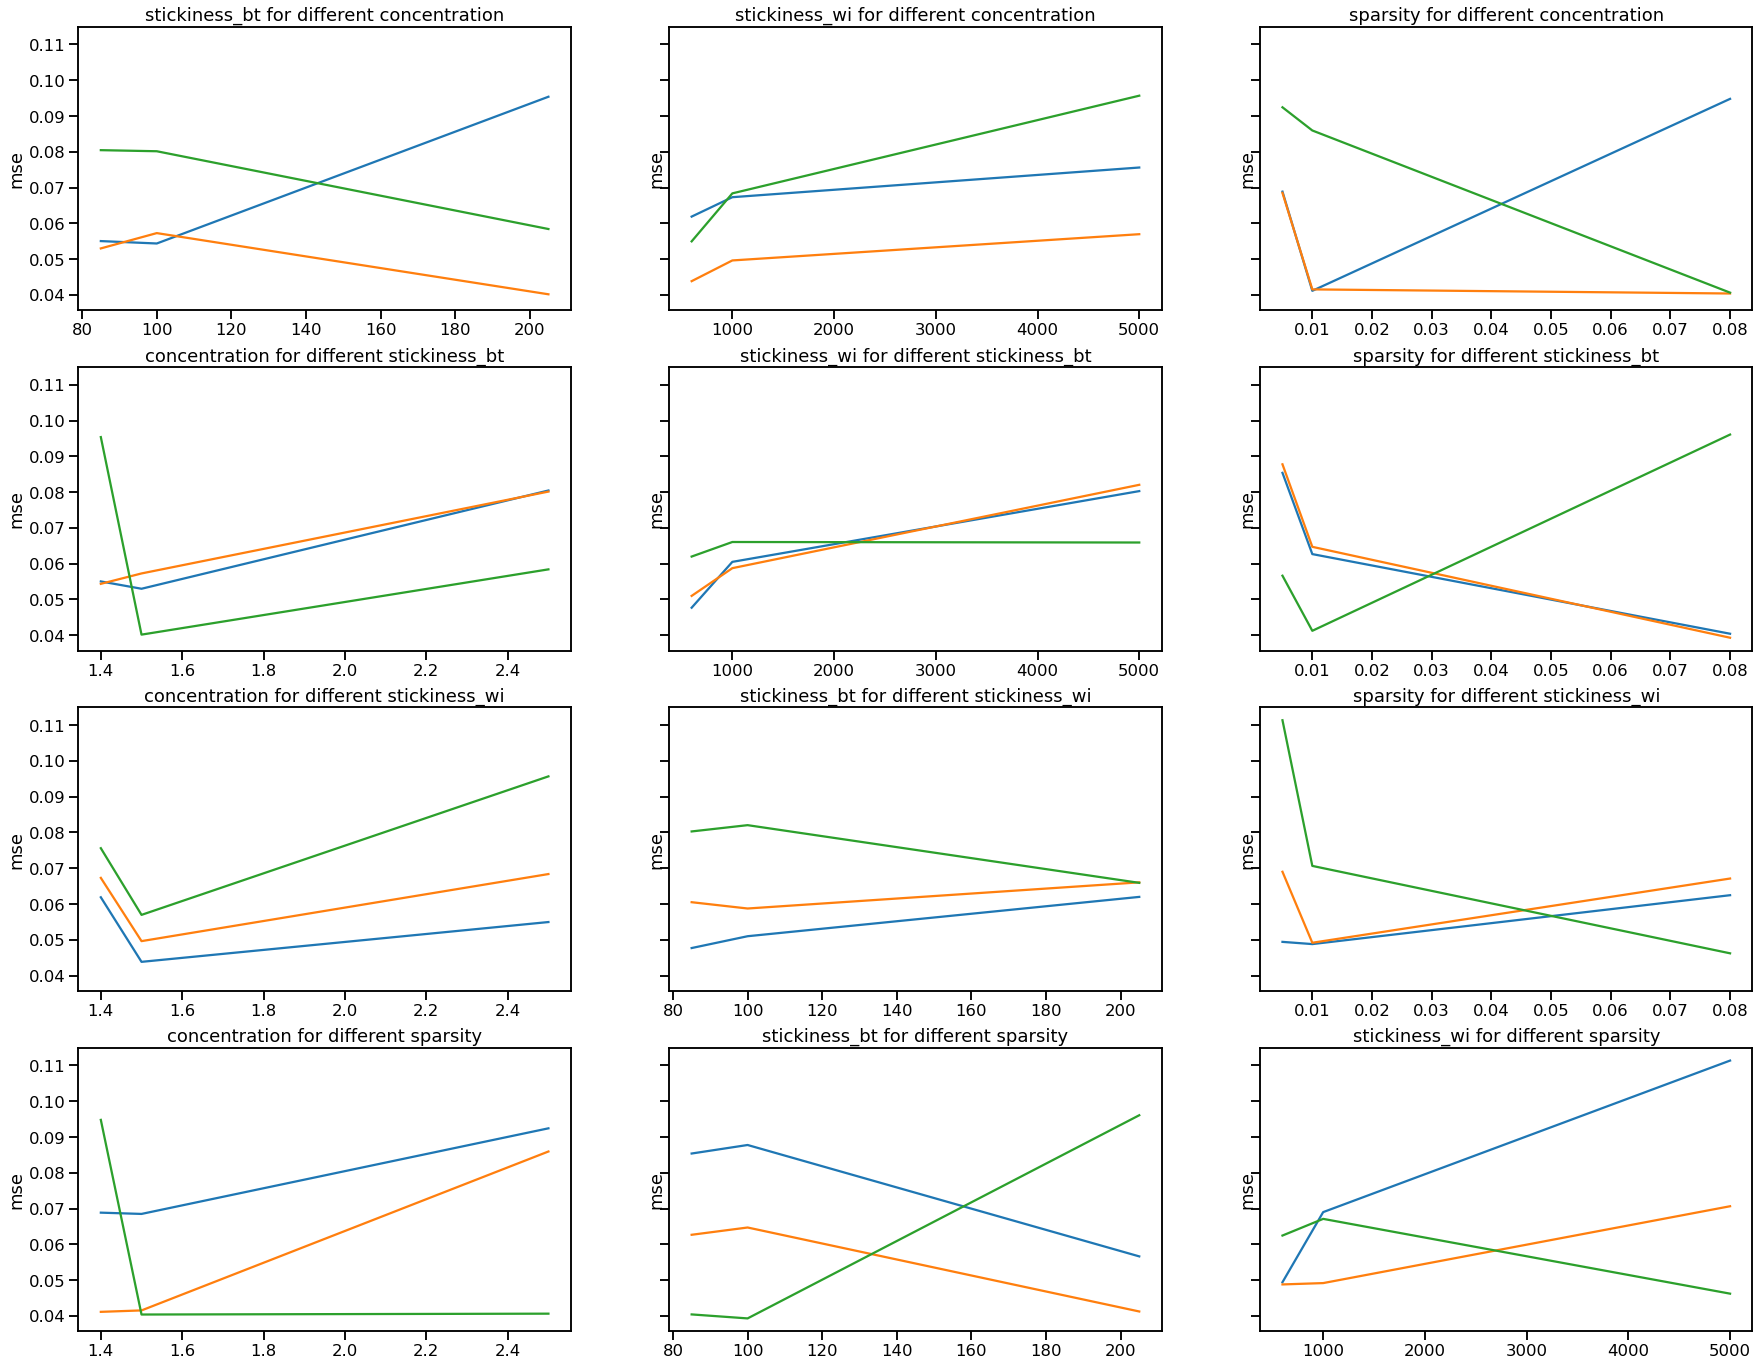

In [12]:
f,axa = plt.subplots(4,3,figsize=(30,24),sharey=True)
for oi,outvar in enumerate(pL):
  ii=-1
  for invar in pL:
    if outvar==invar: continue
    ii+=1
    ax = axa[oi,ii]
    for oval,d in gsdf.groupby([outvar,invar]).mean().groupby(outvar):
      xplt = d.reset_index().loc[:,invar]
      yplt = d.mse.values
      ax.set_title('%s for different %s'%(invar,outvar))
      ax.plot(xplt,yplt)
      
#       ax.bar(range(len(yplt)),yplt)
#       ax.set_xticklabels(xplt)
      ax.set_ylabel('mse')
#       ax.set_ylim(0,0.025)
      
plt.savefig('figures/scratch/mse-by-paramXparam-%i'%tstamp)